## Series temporales a los tópicos

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from utils import cargar_dataset, agrupar, generar_random_walk, generar_ruido_blanco

In [18]:
# 1. Cargar datos
df = cargar_dataset(acotar=True)

df.head()

,id,timestamp,provincia,titulo,sentimiento,Hostelería y Turismo,Sanitario y Salud,Educación y Formación,Tecnología y Telecomunicaciones,Construcción e Inmobiliaria,...,Administración y Finanzas,"Cultura, Arte y Ocio",topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
0,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Asturias,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.041404,0.120992,0.041573,0.059019,0.030701,...,0.324229,0.019733,0.026325,0.026326,0.814183,0.026330,0.027860,0.026326,0.026325,0.026325
1,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Huesca,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,0,0.030990,0.057478,0.036322,0.029180,0.147316,...,0.018703,0.017910,0.009713,0.688852,0.009849,0.009813,0.009709,0.252614,0.009740,0.009709
2,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Las Palmas,EDUCADORES SOCIALES,0,0.091403,0.192666,0.193061,0.050125,0.051813,...,0.115608,0.070124,0.057161,0.332506,0.055559,0.331964,0.055559,0.055561,0.056131,0.055560
3,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Islas Baleares,PIZZERO (REF. 042025002051),0,0.322015,0.063957,0.053818,0.034641,0.071745,...,0.064199,0.136239,0.595359,0.023262,0.023261,0.134708,0.023259,0.023263,0.153550,0.023339
4,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Santa Cruz de Tenerife,INTÉRPRETES DE LA LENGUA DE SIGNOS,0,0.080653,0.092984,0.213507,0.103557,0.021882,...,0.032568,0.312488,0.026320,0.026772,0.026344,0.026321,0.026319,0.026320,0.814982,0.026622


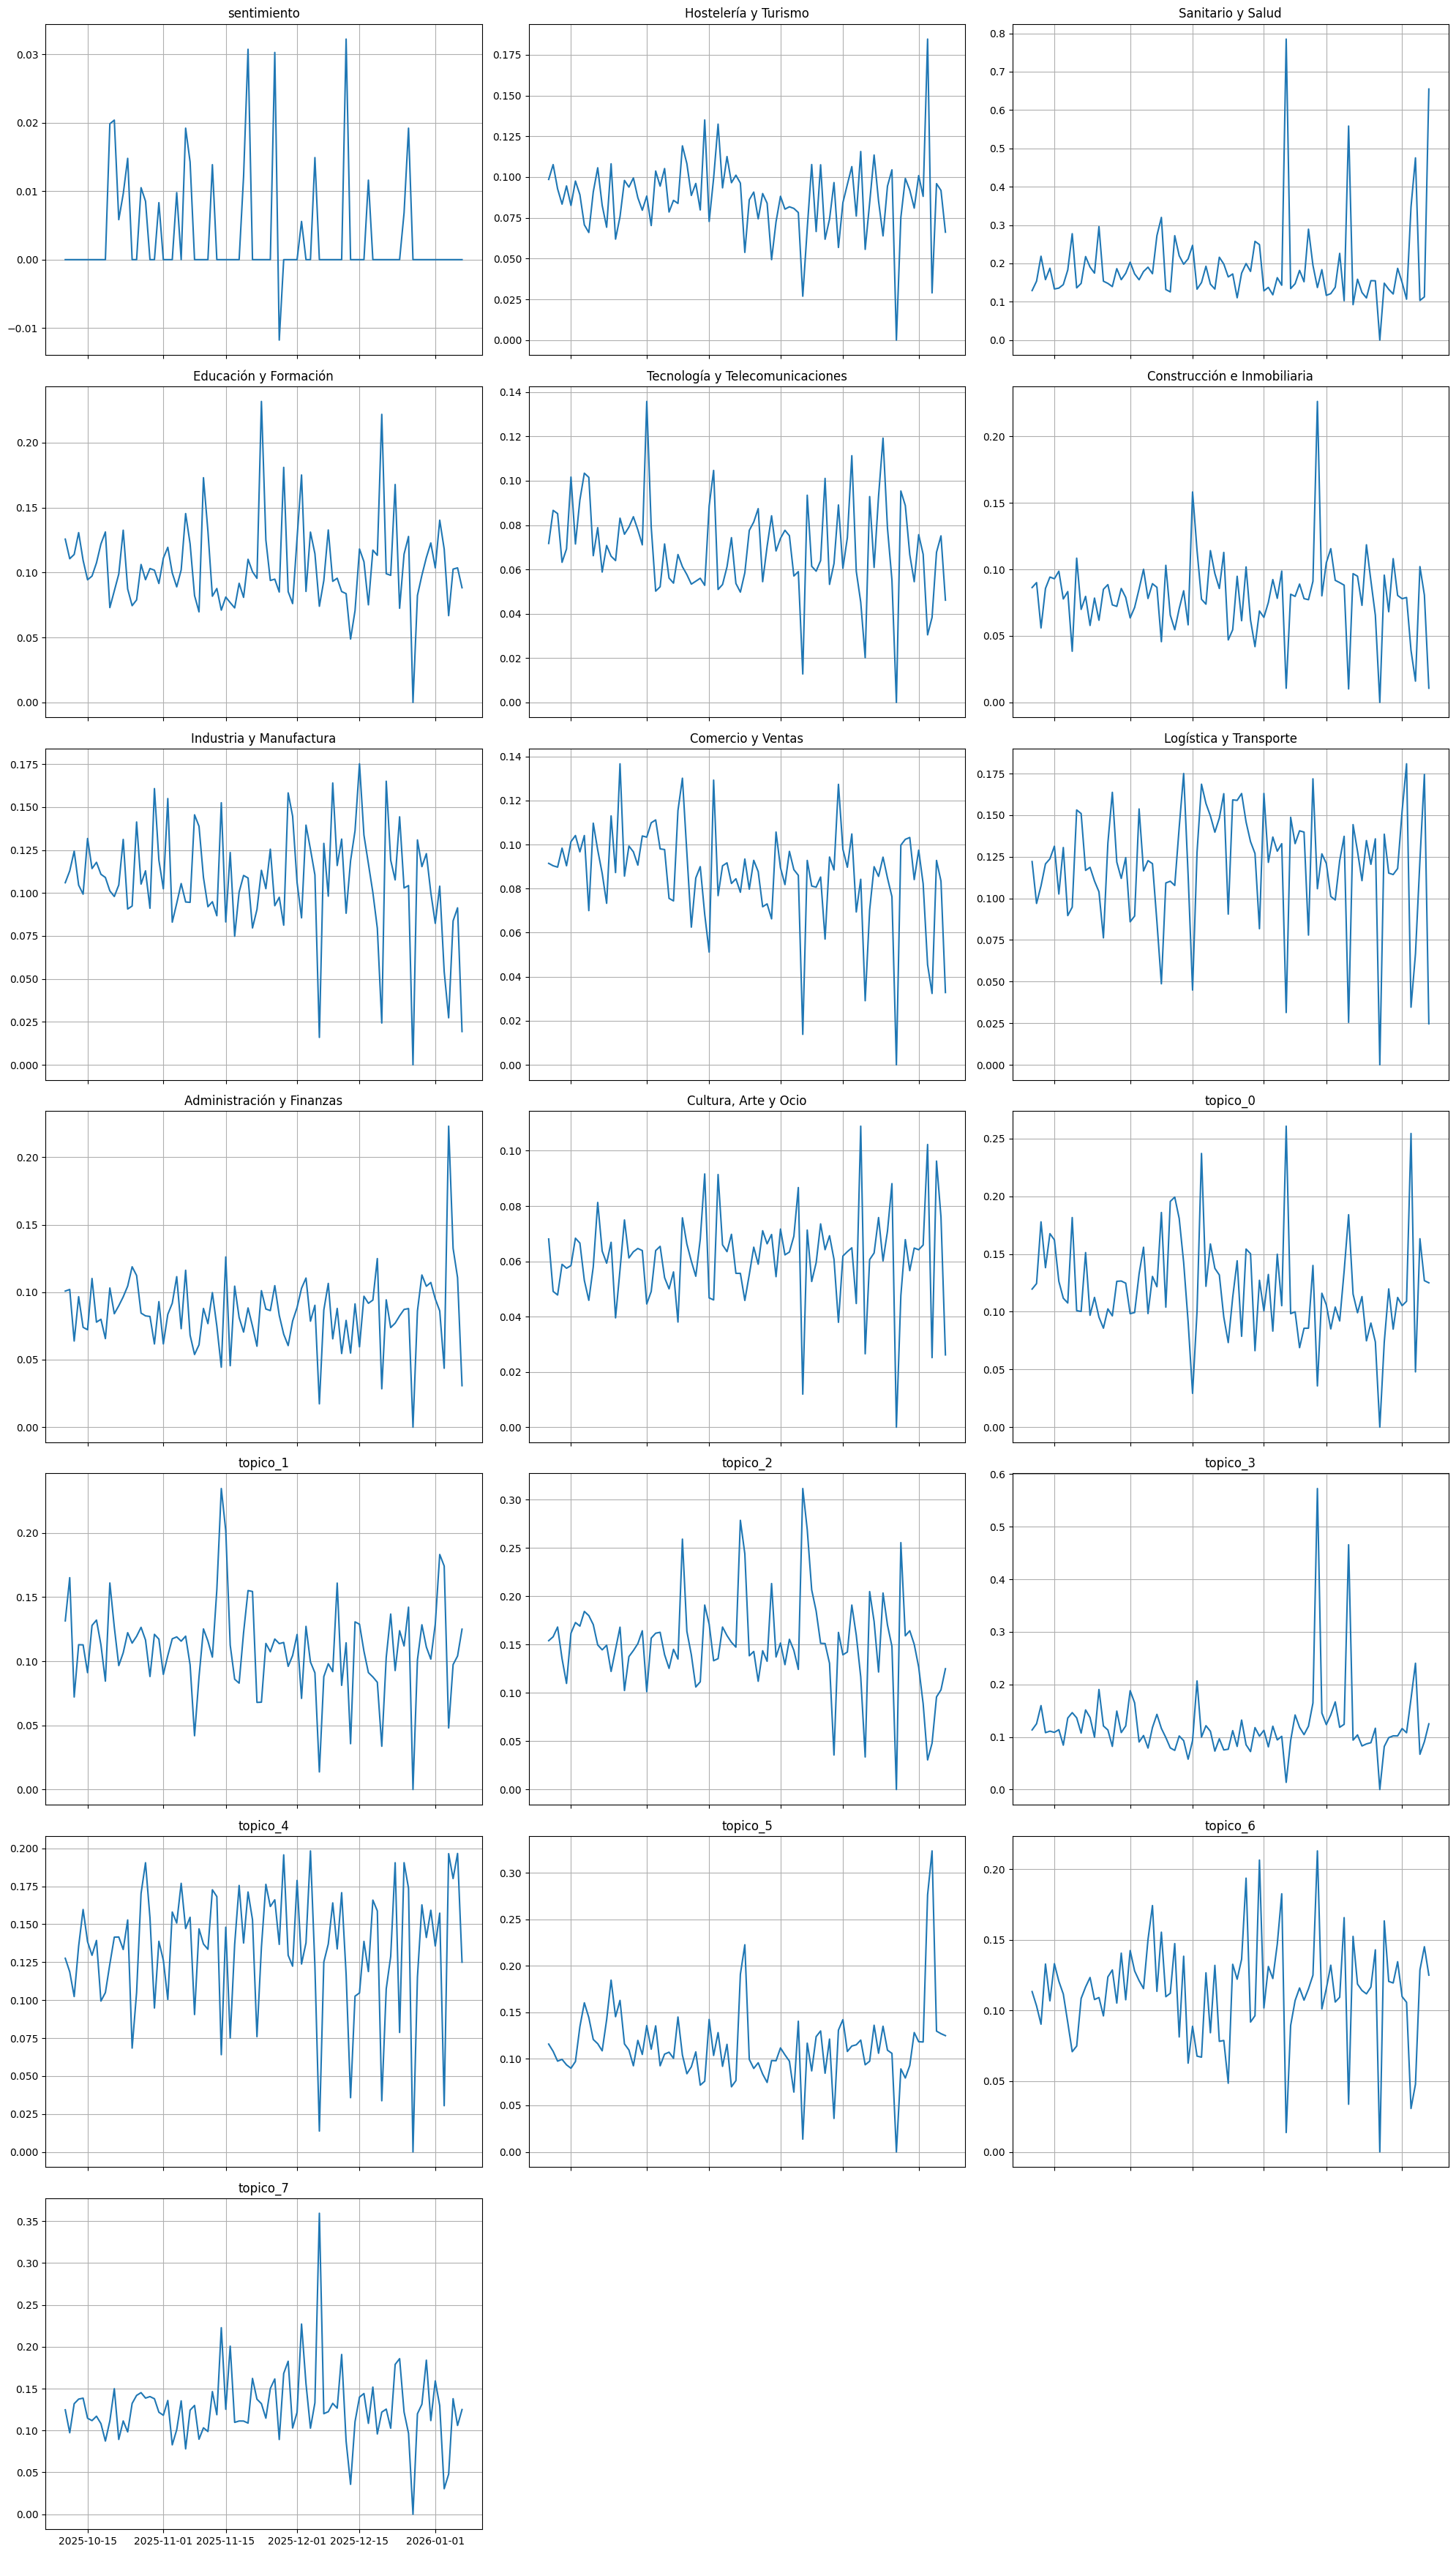

In [19]:
columnas_excluir = ["provincia", "titulo", "id", "timestamp"]
indicadores = [col for col in df.columns if col not in columnas_excluir]

# 3. Configurar subplots: 3 por fila
n_cols = 3
n_rows = int(np.ceil(len(indicadores) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True)
axes = axes.flatten()

# 4. Graficar cada indicador en su subplot
for i, indicador in enumerate(indicadores):
    series_diaria = agrupar(df, indicador, freq="D")
    axes[i].plot(series_diaria.index, series_diaria.values)
    axes[i].set_title(indicador)
    axes[i].grid(True)

# 5. Eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [20]:
# Lista de tópicos a procesar 
topicos = [col for col in df.columns if 'topico' in col]

series_dict = {}

for indicador in topicos:
    # Agrupar por días
    serie = agrupar(df, indicador, freq="D")
    serie = serie.replace(0, np.nan).ffill()
    series_dict[indicador] = serie

# Crear un nuevo DataFrame con todas las series procesadas
df_series_temporales = pd.DataFrame(series_dict)

df_series_temporales

,topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
timestamp,,,,,,,,
2025-10-10,0.119587,0.131459,0.153999,0.113355,0.127572,0.115938,0.113386,0.124704
2025-10-11,0.124357,0.165141,0.158053,0.125143,0.118666,0.108106,0.103245,0.097288
2025-10-12,0.177816,0.072119,0.168140,0.159695,0.102363,0.097574,0.090305,0.131989
2025-10-13,0.138142,0.112881,0.135292,0.108233,0.135611,0.099507,0.132872,0.137462
2025-10-14,0.167609,0.112767,0.109777,0.111071,0.159719,0.093592,0.106850,0.138615
...,...,...,...,...,...,...,...,...
2026-01-03,0.254355,0.174218,0.030620,0.172728,0.030433,0.276452,0.030719,0.030475
2026-01-04,0.047901,0.047996,0.047956,0.240220,0.196511,0.323616,0.047901,0.047900
2026-01-05,0.163206,0.097385,0.095829,0.067027,0.180086,0.129854,0.128644,0.137969


Buscamos estacionariedad y estacionalidad en las series temporales.

In [21]:
# 4. Test de estacionariedad (ADF)
resultados_adf = []

for column in df_series_temporales.columns:
    result = adfuller(df_series_temporales[column].dropna())
    adf_stat = result[0]
    p_value = round(result[1], 3)
    es_estacionaria = p_value < 0.05
    
    resultados_adf.append({
        'Topico': column,
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Estacionaria': es_estacionaria
    })

# Convertir a DataFrame para mejor visualización
pd.DataFrame(resultados_adf)


,Topico,ADF Statistic,p-value,Estacionaria
0,topico_0,-9.067007,0.000,True
1,topico_1,-3.463608,0.009,True
2,topico_2,-6.525954,0.000,True
3,topico_3,-8.377698,0.000,True
4,topico_4,-1.999306,0.287,False
5,topico_5,-6.454042,0.000,True
6,topico_6,-9.037406,0.000,True
7,topico_7,-8.698243,0.000,True


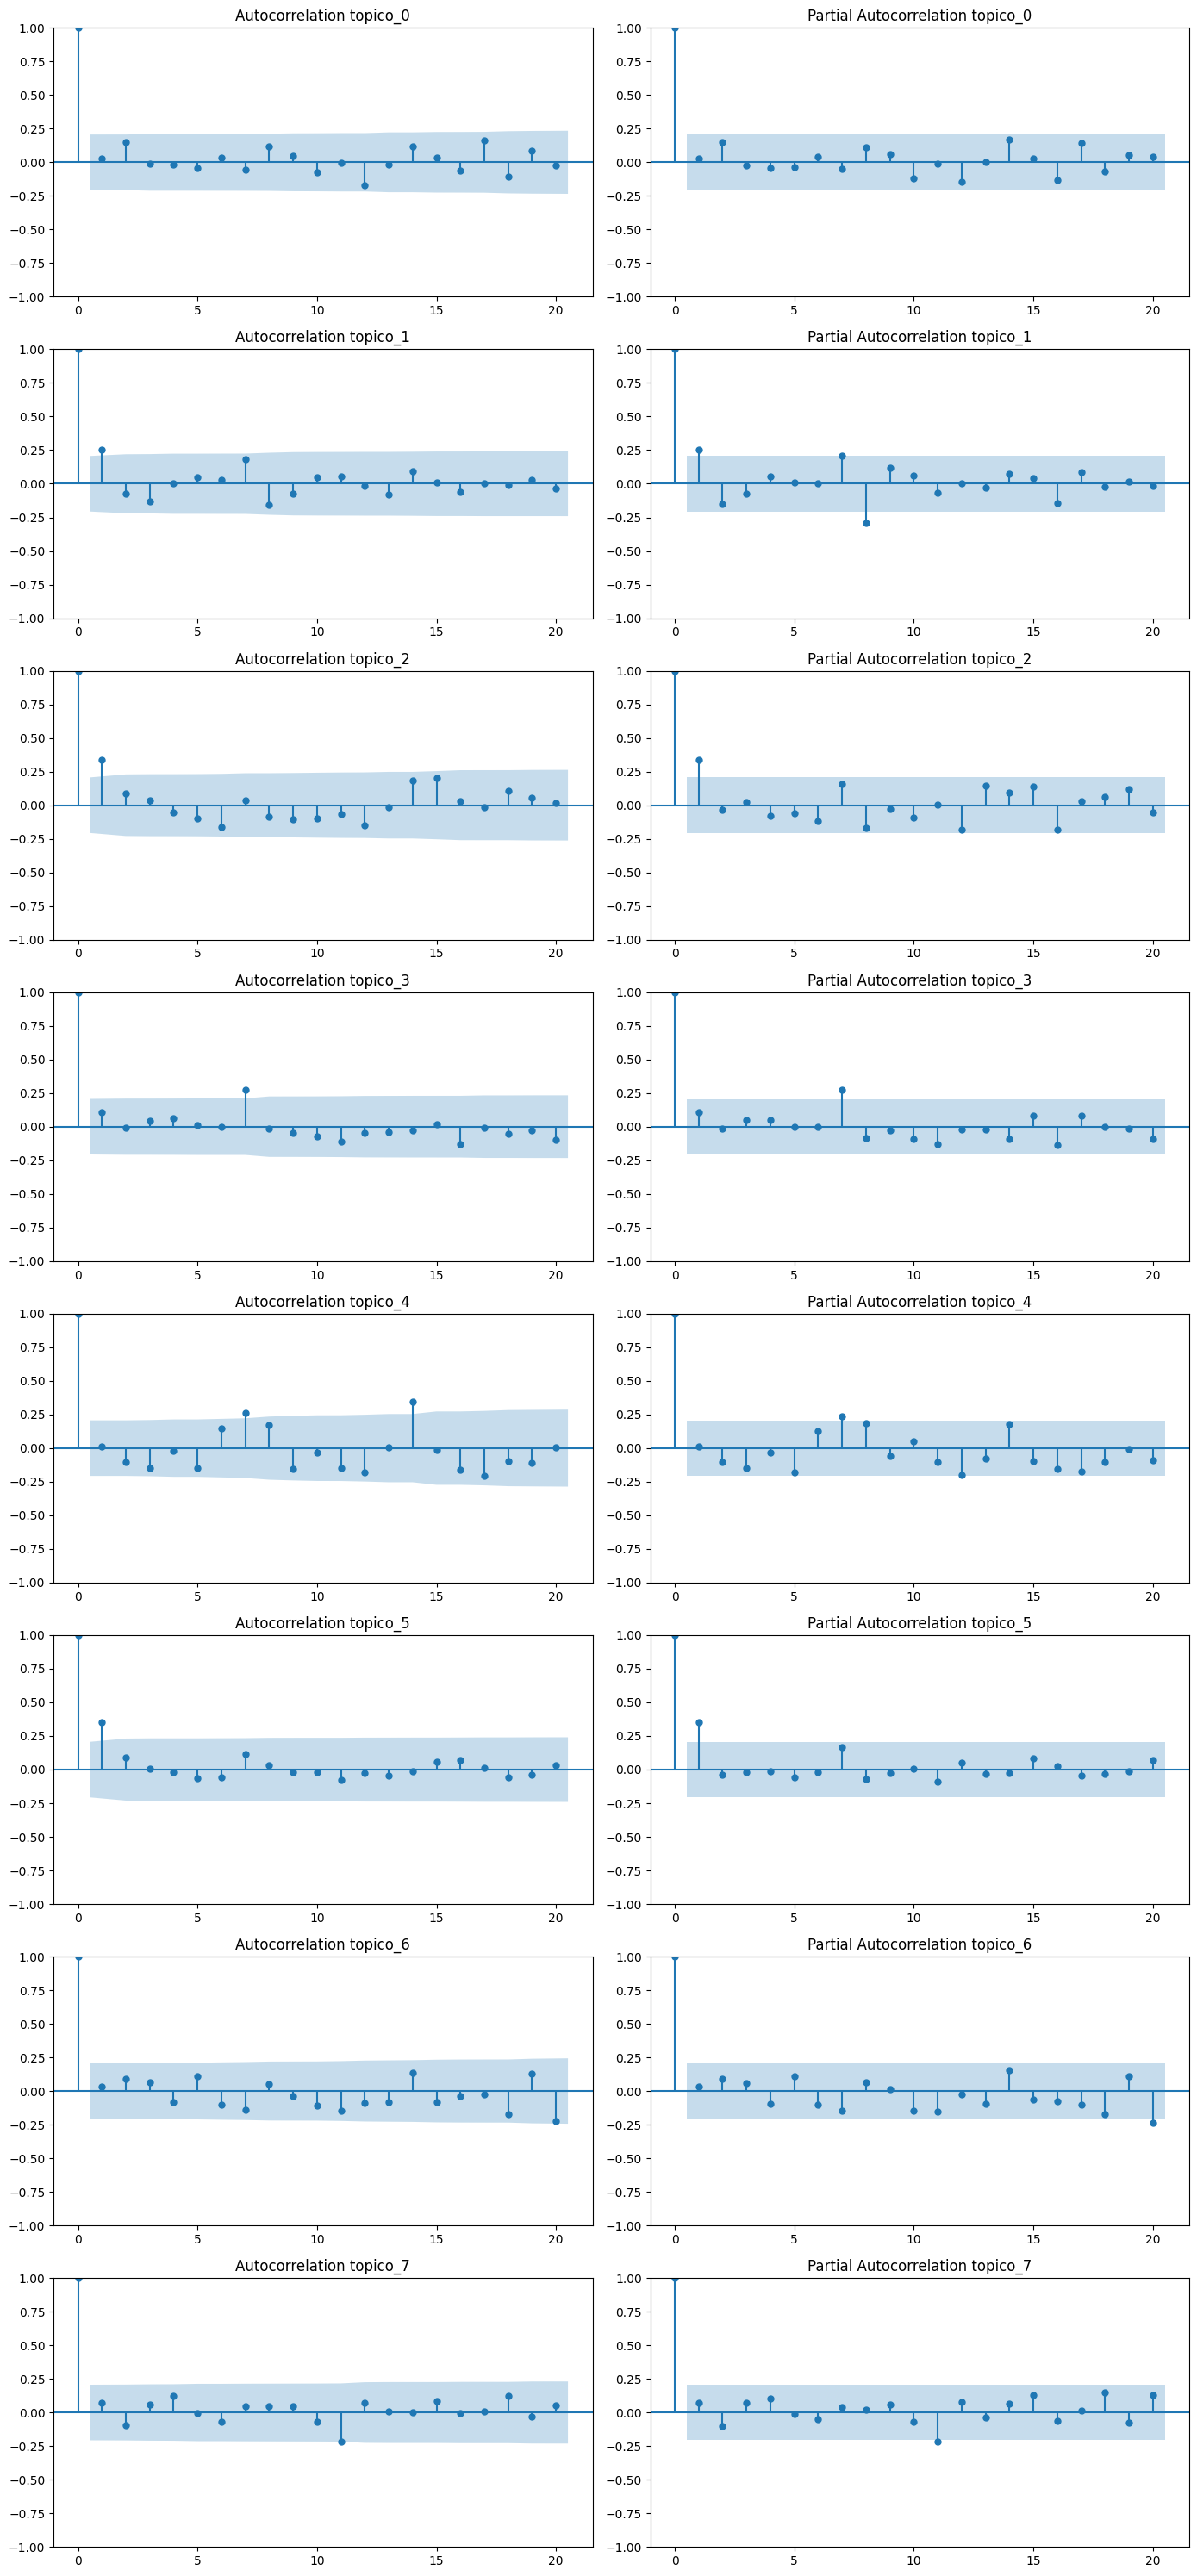

In [53]:
fig, axes = plt.subplots(8, 2, figsize=(14, 30))

for i, column in enumerate(df_series_temporales.columns):

    plot_acf(df_series_temporales[column], lags=20, ax=axes[i, 0], title=f'Autocorrelation {column}')
    plot_pacf(df_series_temporales[column], lags=20, ax=axes[i, 1], title=f'Partial Autocorrelation {column}')

plt.tight_layout()
plt.show()

#### Tópico 4
Este es el único tópico que el test de Dickey-Fuller identificó como no estacionario con un p-value muy alto de 0.872. Esto indica que la serie debe ser tratada con diferenciación.

Al observar sus correlogramas (ACF/PACF), destaca un patrón de dependencia estacional significativa cada 7 y 14 días. Para capturar esta estructura, un suavizado exponencial simple no es suficiente.

#### Tópico 3
El test ADF muestra un p-value de 0.000 lo que confirma que la serie es estacionaria.

Sin embargo, al analizar los correlogramas, observamos estacionalidad cada 7 días. Esto nos indica que su comportamiento parece estar regido por un ciclo semanal.

#### Resto de Tópicos (0, 1, 2, 5, 6, 7)
Estos tópicos son estacionarios y muestran una memoria más corta.

# ANALIZAR LOS GRÁFICOS DE ABAJO PARA DETERMINAR SI HAY TENDENCIA O NO 

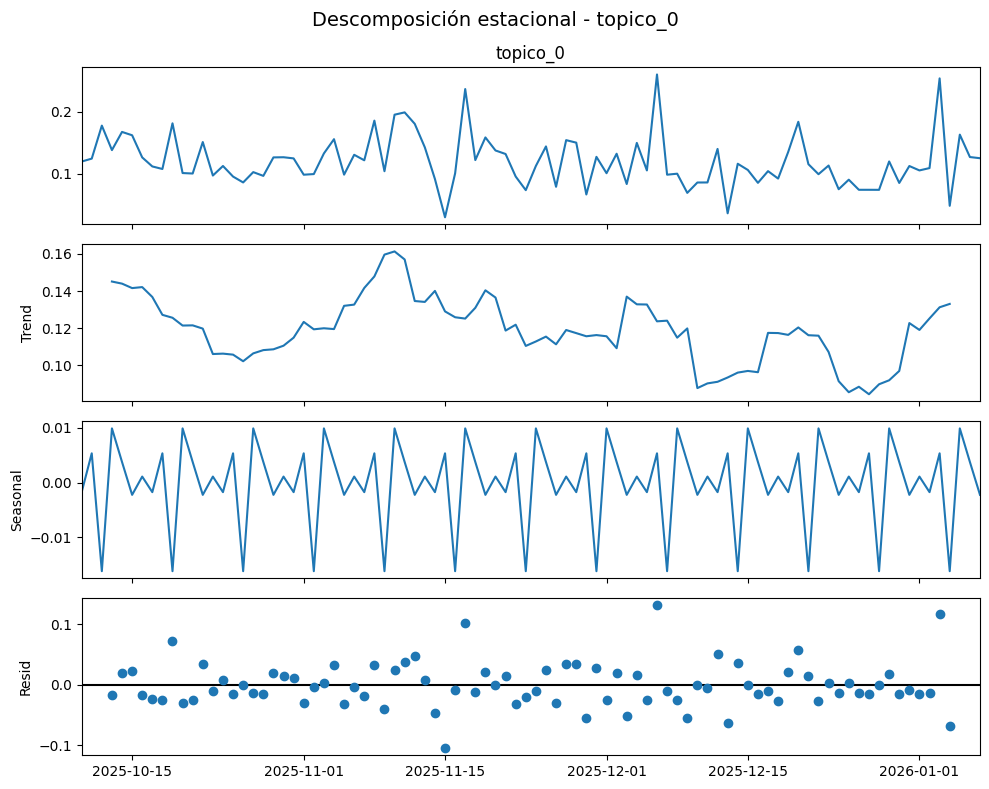

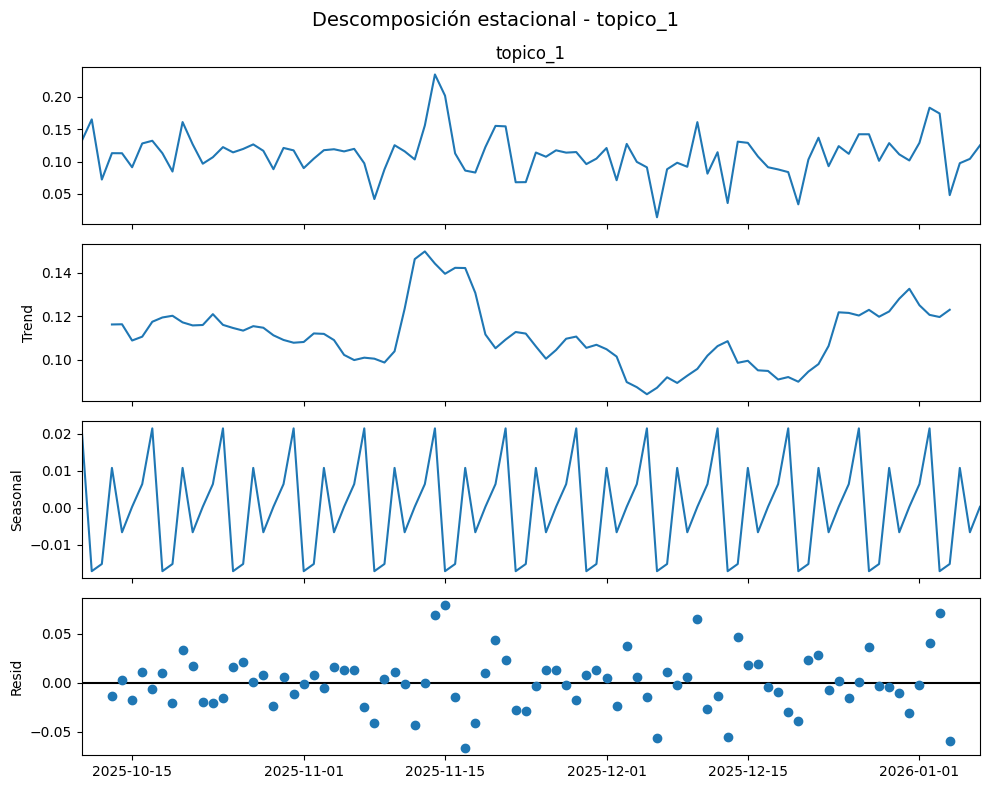

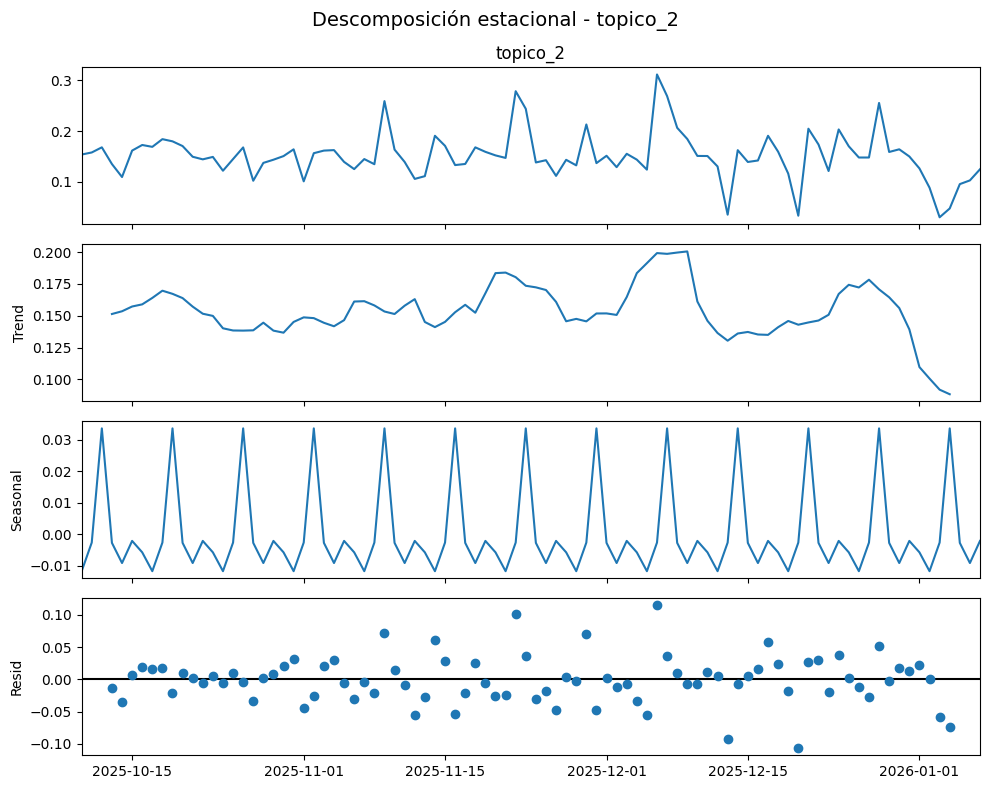

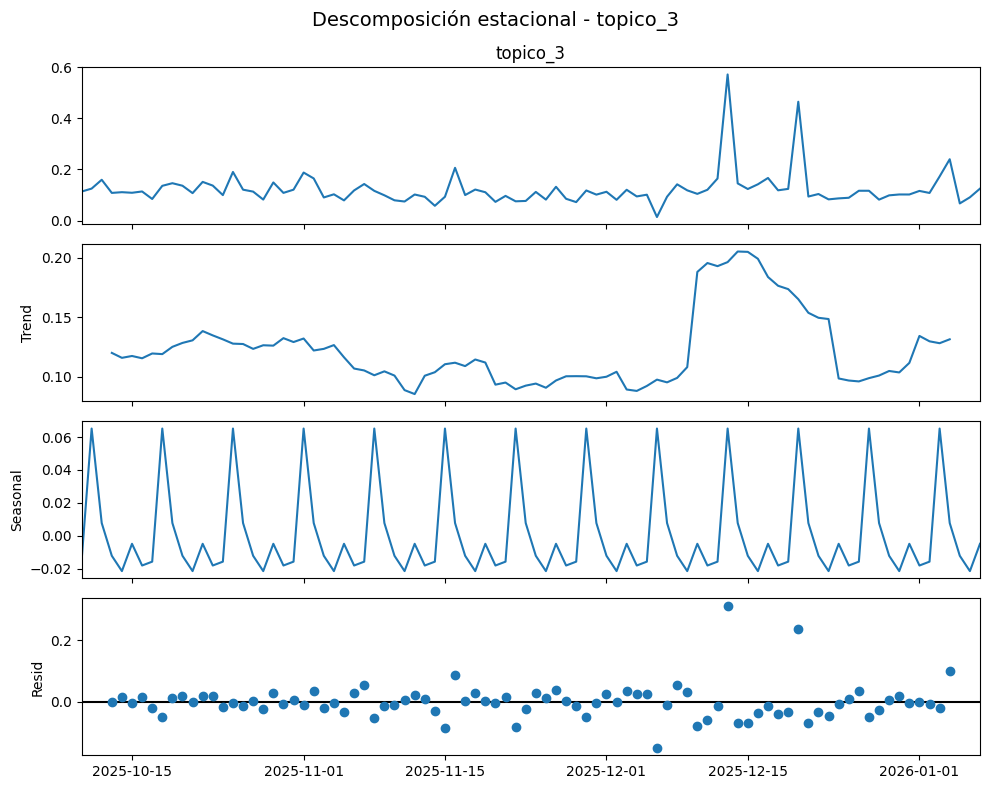

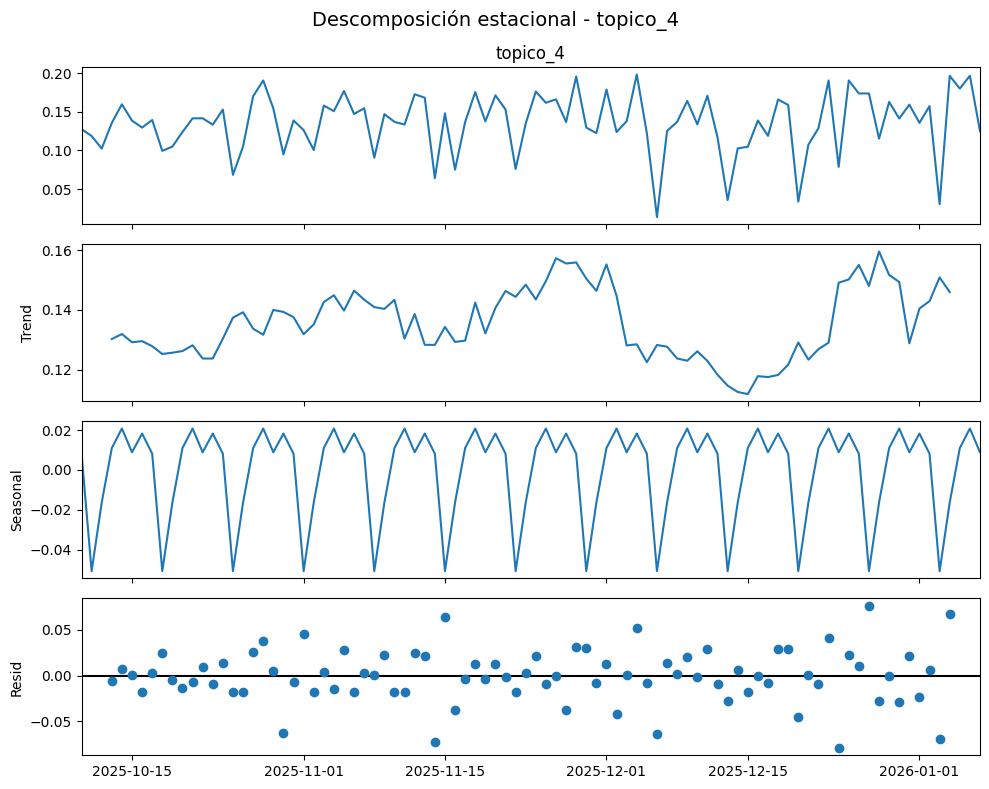

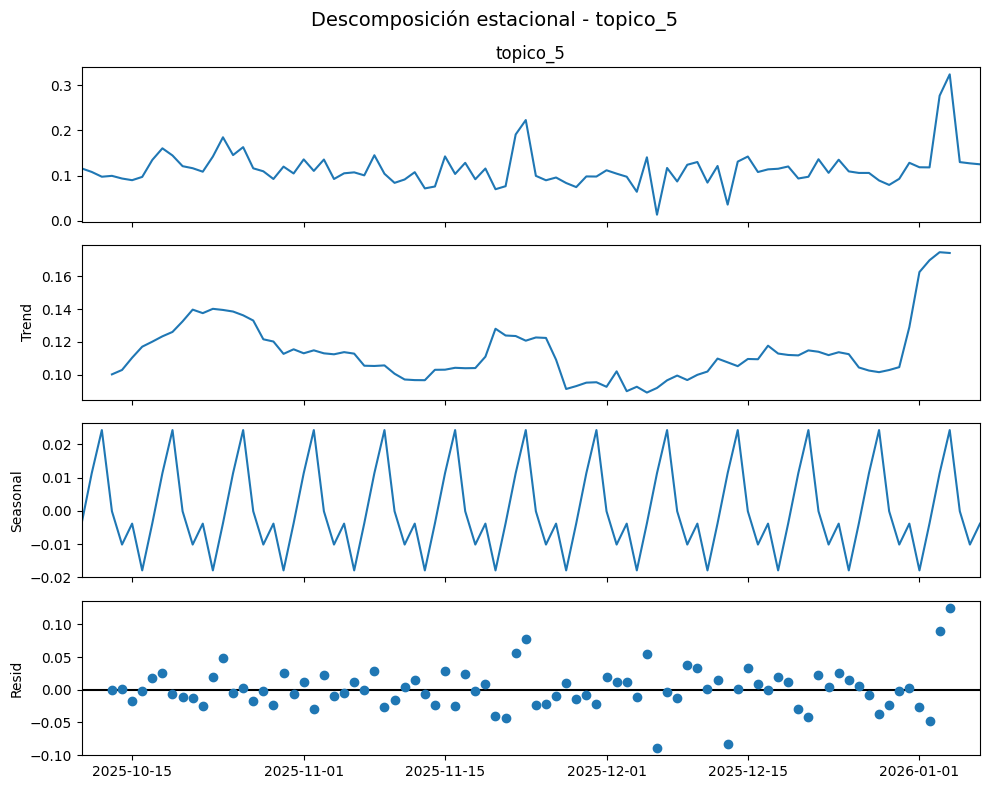

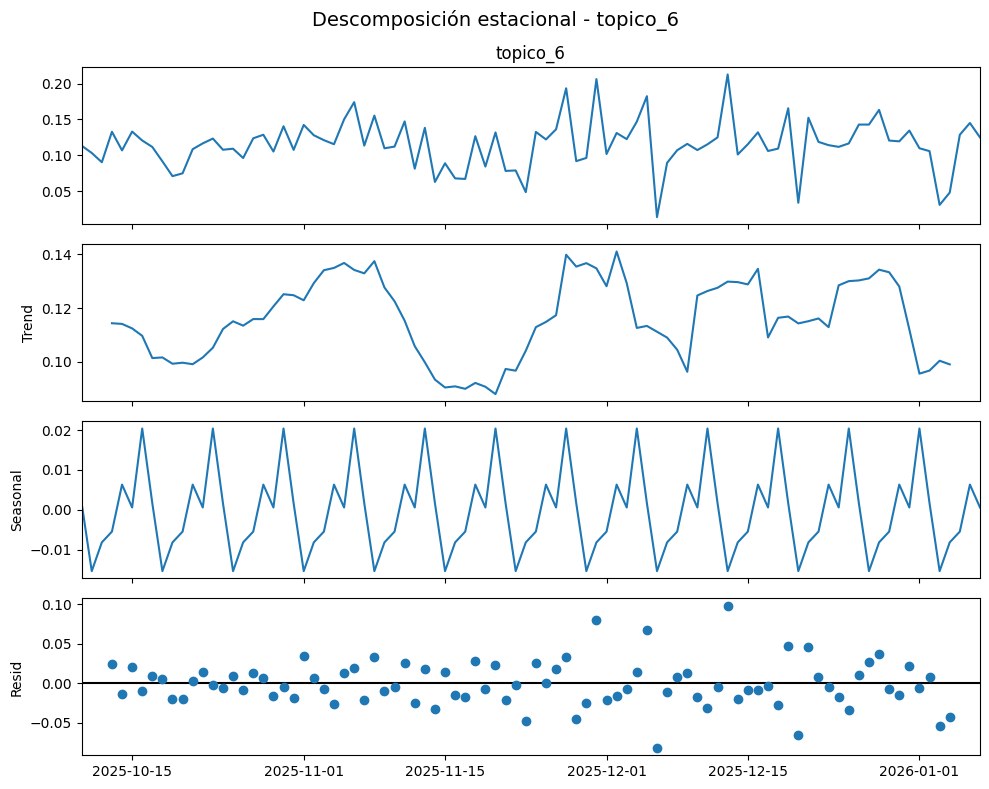

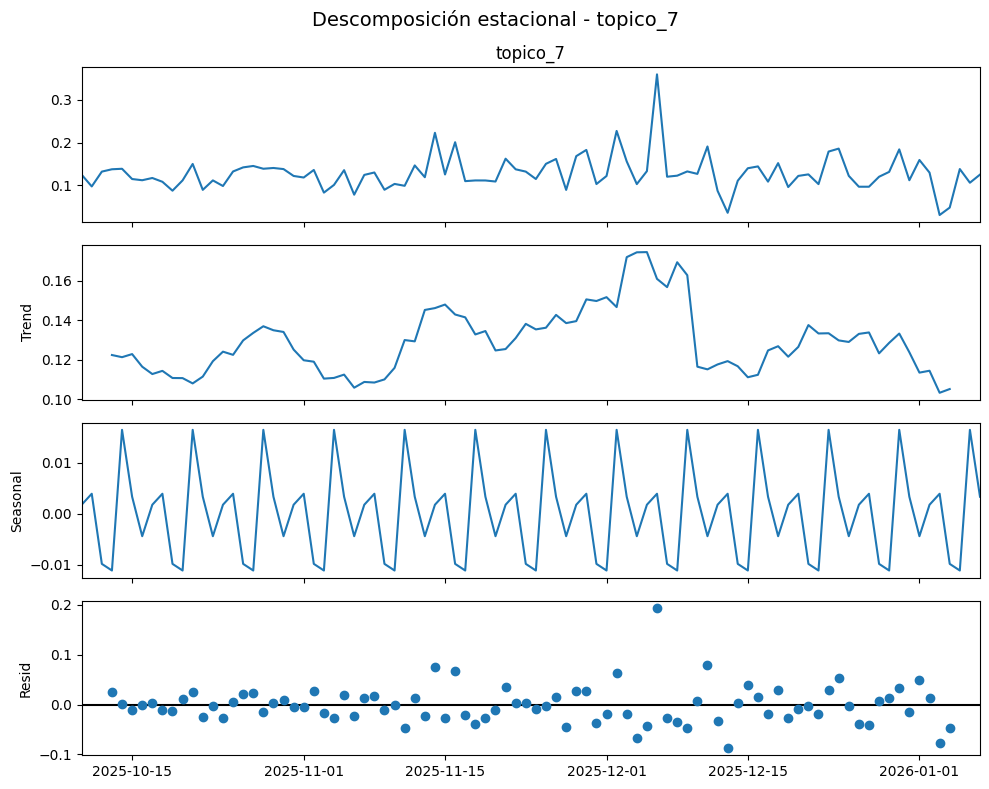

In [55]:
for i, column in enumerate(df_series_temporales.columns):
    series = df_series_temporales[column]
    result = seasonal_decompose(series, model="additive", period=7)

    ax_idx = i * 4  
    fig_topic = result.plot()
    fig_topic.set_size_inches(10, 8) 
    fig_topic.suptitle(f"Descomposición estacional - {column}", fontsize=14)
    plt.tight_layout() 
    plt.show()


### Aplicación de suavizado exponencial 

# REPLICAR EL CODIGO DE ABAJO CON CADA TOPICO SEGÚN SI TIENE TENDENCIA O NO AJUSTAR EL MODEO EXPONENCIAL (Y PUEDE QUE EL ARIMA)

In [ ]:
from statsmodels.tsa.statespace.sarimax import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd

# 1. CONFIGURACIÓN
nombre_topico = 'topico_0' 
orden_sarima = (1, 1, 1)    

print(f"Generando modelos para: {nombre_topico} (Estacionario)")

# Preparar datos
series = df_series_temporales[nombre_topico] # CAMBIADO: Fuente de datos
future_days = 7

# Dividir los datos en entrenamiento y prueba
train_series = series[:-future_days]
test_series = series[-future_days:]

# 2. SUAVIZADO EXPONENCIAL SIMPLE
hw_model = ExponentialSmoothing(
    train_series,
    trend=None,
    seasonal=None
).fit()
hw_pred = hw_model.forecast(future_days)

# 3. SARIMAX
sarima_model = ARIMA(
    train_series,
    order=orden_sarima
).fit(disp=False)
sarima_pred = sarima_model.forecast(steps=future_days)

# 4. VISUALIZACIÓN
plt.figure(figsize=(12, 5))
plt.plot(train_series.index[-30:], train_series.tail(30), label='Histórico (30 días)', color='blue') 
plt.plot(test_series.index, test_series, label='Datos Reales', color='green') 
plt.plot(hw_pred.index, hw_pred, label='suavizado exponencial triple', linestyle='--', marker='o', color='purple') 
plt.plot(sarima_pred.index, sarima_pred, label=f'SARIMA {orden_sarima}', linestyle='--', marker='x', color='darkgoldenrod') #
plt.title(f'Predicción y Validación a 7 días: {nombre_topico}') 
plt.legend()
plt.grid()
plt.show()

Generando modelos para: topico_0 (Estacionario)


C:\Users\alvar\AppData\Local\Temp\ipykernel_13376\4009716483.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df[nombre_topico].asfreq('D').fillna(method='ffill')


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

# comprobar el codigo de abajo la parte del suavizado con diff pq no se si esta bien

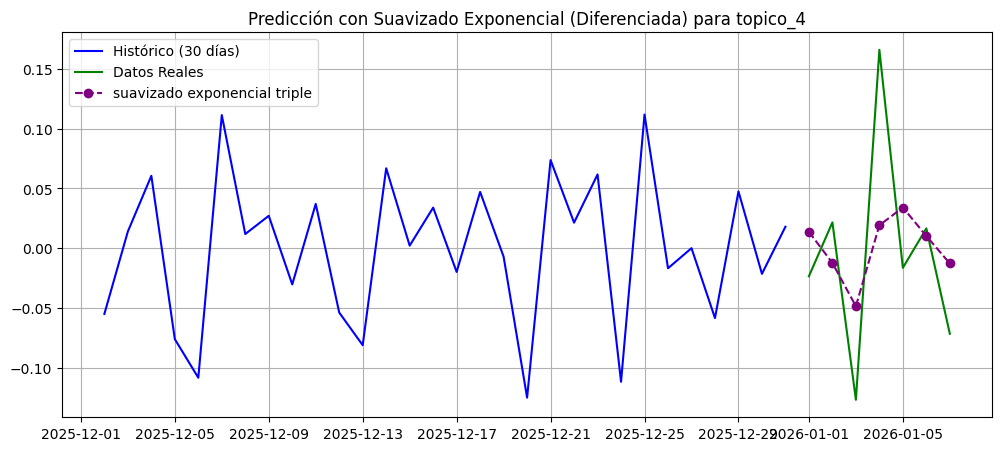

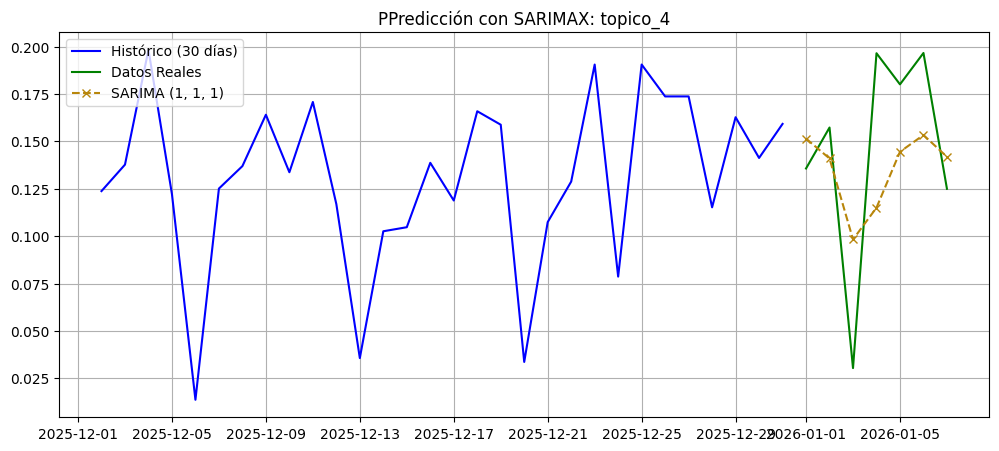

In [58]:
nombre_topico = 'topico_4'
series = df_series_temporales[nombre_topico]
diff_series = series.diff().dropna()

future_days = 7
orden_sarima = (1, 1, 1)    
orden_seasonal = (1, 0, 1, 7) 

# Dividir los datos en entrenamiento y prueba
train_series = series[:-future_days]
test_series = series[-future_days:]

train_series_diff = diff_series[:-future_days]
test_series_diff = diff_series[-future_days:]

# 2. SUAVIZADO EXPONENCIAL Triple
hw_model = ExponentialSmoothing(
    train_series_diff,
    trend='add', 
    seasonal='add', 
    seasonal_periods=7).fit()

hw_pred = hw_model.forecast(future_days)

# 3. SARIMAX
sarima_model = SARIMAX(
    train_series,
    order=orden_sarima,
    seasonal_order=orden_seasonal).fit(disp=False)
    
sarima_pred = sarima_model.forecast(steps=future_days)


# Gráfico 1: Suavizado Exponencial 
plt.figure(figsize=(12, 5))
plt.plot(train_series_diff.index[-30:], train_series_diff.tail(30), label='Histórico (30 días)', color='blue')
plt.plot(test_series_diff.index, test_series_diff, label='Datos Reales', color='green')
plt.plot(hw_pred.index, hw_pred, label='suavizado exponencial triple', linestyle='--', marker='o', color='purple')
plt.title(f'Predicción con Suavizado Exponencial (Diferenciada) para {nombre_topico}')
plt.legend()
plt.grid()
plt.show()

# Gráfico 2: SARIMAX 
plt.figure(figsize=(12, 5))
plt.plot(train_series.index[-30:], train_series.tail(30), label='Histórico (30 días)', color='blue')
plt.plot(test_series.index, test_series, label='Datos Reales', color='green')
plt.plot(sarima_pred.index, sarima_pred, label=f'SARIMA {orden_sarima}', linestyle='--', marker='x', color='darkgoldenrod')
plt.title(f'PPredicción con SARIMAX: {nombre_topico}')
plt.legend()
plt.grid()
plt.show()


# aqui me he quedado

In [30]:
resultados_adf_returns = []
for column in df_series_temporales.columns:
    # Calculate the returns of the series
    series_returns = df_series_temporales[column].pct_change().dropna()
    if not series_returns.empty:
        result = adfuller(series_returns)
        adf_stat = result[0]
        p_value = round(result[1], 3)
        es_estacionaria = p_value < 0.05
        
        resultados_adf_returns.append({
            'Topico': column,
            'ADF Statistic (Returns)': adf_stat,
            'p-value (Returns)': p_value,
            'Estacionaria (Returns)': es_estacionaria
        })
    else:
        resultados_adf_returns.append({
            'Topico': column,
            'ADF Statistic (Returns)': None,
            'p-value (Returns)': None,
            'Estacionaria (Returns)': False
        })

pd.DataFrame(resultados_adf_returns)



,Topico,ADF Statistic (Returns),p-value (Returns),Estacionaria (Returns)
0,topico_0,-13.436305,0.000,True
1,topico_1,-2.649787,0.083,False
2,topico_2,-2.911329,0.044,True
3,topico_3,-11.093620,0.000,True
4,topico_4,-11.346118,0.000,True
5,topico_5,-11.397204,0.000,True
6,topico_6,-11.998932,0.000,True
7,topico_7,-7.516076,0.000,True


el único que parece tener residuos no estacionario es el topico 1

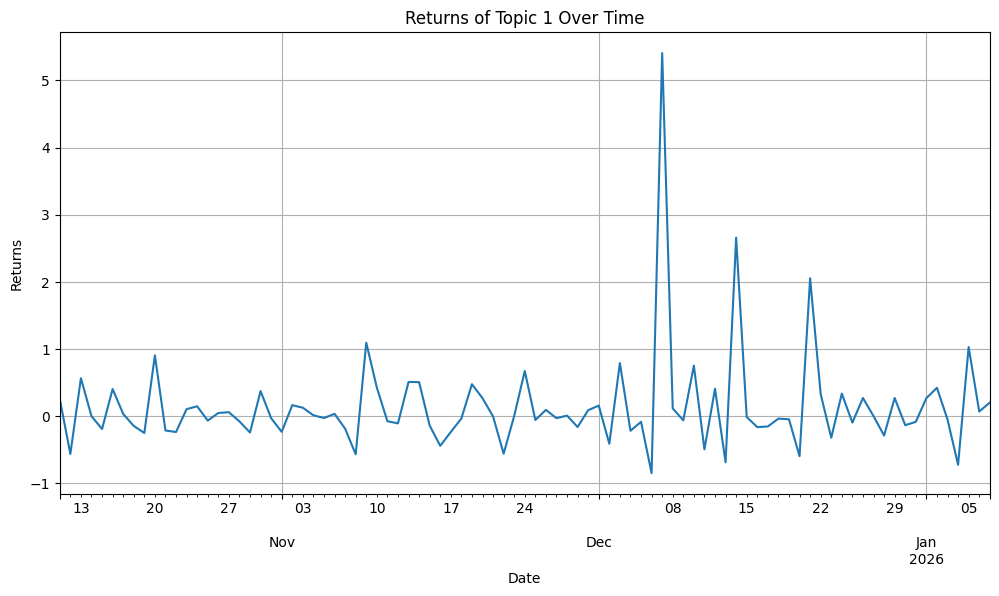

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_series_temporales["topico_1"].pct_change().dropna().plot(kind='line')
plt.title('Returns of Topic 1 Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.show()
